## 1. A partir de los excels con los datos de accidentes de tráfico del municipio de Madrid, vamos a proceder a preparar los datos para poder construir un modelo predictivo con ML.

El tratamiento inicial va a ser muy similar al llevado a cabo durante la ETL, con la diferencia de que en este caso vamos a prestar más atención a los nulos, eliminando todas aquellas columnas y filas que consideremos que se puede prescindir de ellas. 

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')  # esto es para quitar prints

pd.set_option('display.max_columns', None)   # mostrar todas las columnas del df
#pd.set_option('display.max_rows', None)   # mostrar todas las filas del df

import regex as re

# para pintar
import pylab as plt
import seaborn as sns

#para que salga el grafico
%matplotlib inline

# Importo KNeighborsClassifier de sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

# Importo DecisionTreeClassifier de sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Importo RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Importo LogisticRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

In [2]:
df_19 = pd.read_excel('../data/2019_Accidentalidad.xlsx')
df_20 = pd.read_excel('../data/2020_Accidentalidad.xlsx')
df_21 = pd.read_excel('../data/2021_Accidentalidad.xlsx')
df_22 = pd.read_excel('../data/2022_Accidentalidad.xlsx')


In [3]:
df_19.head()

,num_expediente,fecha,hora,localizacion,numero,cod_distrito,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,cod_lesividad,lesividad,coordenada_x_utm,coordenada_y_utm,positiva_alcohol,positiva_droga
0,2018S017842,2019-02-04,09:10:00,"CALL. ALBERTO AGUILERA, 1",1,1,CENTRO,Colisión lateral,Despejado,Motocicleta > 125cc,Conductor,De 45 a 49 años,Hombre,7.0,Asistencia sanitaria sólo en el lugar del acci...,440068.049,4475679.170,N,NaN
1,2018S017842,2019-02-04,09:10:00,"CALL. ALBERTO AGUILERA, 1",1,1,CENTRO,Colisión lateral,Despejado,Turismo,Conductor,De 30 a 34 años,Mujer,7.0,Asistencia sanitaria sólo en el lugar del acci...,440068.049,4475679.170,N,NaN
2,2019S000001,2019-01-01,03:45:00,PASEO. SANTA MARIA DE LA CABEZA / PLAZA. ELIPTICA,168,11,CARABANCHEL,Alcance,NaN,Furgoneta,Conductor,De 40 a 44 años,Hombre,NaN,NaN,439139.603,4470836.854,S,NaN
3,2019S000001,2019-01-01,03:45:00,PASEO. SANTA MARIA DE LA CABEZA / PLAZA. ELIPTICA,168,11,CARABANCHEL,Alcance,NaN,Turismo,Conductor,De 40 a 44 años,Mujer,NaN,NaN,439139.603,4470836.854,N,NaN
4,2019S000001,2019-01-01,03:45:00,PASEO. SANTA MARIA DE LA CABEZA / PLAZA. ELIPTICA,168,11,CARABANCHEL,Alcance,NaN,Turismo,Conductor,De 45 a 49 años,Mujer,NaN,NaN,439139.603,4470836.854,N,NaN


In [4]:
df_19_1 = df_19.copy()
df_20_1 = df_20.copy()
df_21_1 = df_21.copy()
df_22_1 = df_22.copy()

In [5]:
#concateno los 4 dataframes en uno para trabajar la limpieza con el dataframe final directamente
df_ori = pd.concat([df_19_1, df_20_1, df_21_1, df_22_1], axis=0)
df_ori.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160020 entries, 0 to 33992
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   num_expediente        160020 non-null  object        
 1   fecha                 160020 non-null  datetime64[ns]
 2   hora                  160020 non-null  object        
 3   localizacion          160020 non-null  object        
 4   numero                160015 non-null  object        
 5   cod_distrito          160015 non-null  float64       
 6   distrito              160015 non-null  object        
 7   tipo_accidente        160016 non-null  object        
 8   estado_meteorológico  143502 non-null  object        
 9   tipo_vehiculo         159513 non-null  object        
 10  tipo_persona          160017 non-null  object        
 11  rango_edad            160020 non-null  object        
 12  sexo                  160020 non-null  object        
 13  

In [6]:
df = df_ori.copy()

In [7]:
#función para checkear todas las columnas y el número de valores nulos que tienen
def check_nan(df: pd.DataFrame) -> None:
    
    nan_cols=df.isna().mean() * 100  # el porcentaje
    
    display(f'N nan cols: {len(nan_cols[nan_cols>0])}')
    display(nan_cols[nan_cols>0])
    
    plt.figure(figsize=(10, 6))  # inicia la figura y establece tamaño

    sns.heatmap(df.isna(),  # mapa de calor
                yticklabels=False,
                cmap='viridis',
                cbar=False)

    plt.show();

'N nan cols: 13'

numero                   0.003125
cod_distrito             0.003125
distrito                 0.003125
tipo_accidente           0.002500
estado_meteorológico    10.322460
tipo_vehiculo            0.316835
tipo_persona             0.001875
cod_lesividad           44.736283
lesividad               44.736283
coordenada_x_utm         0.016873
coordenada_y_utm         0.016873
positiva_alcohol         0.343707
positiva_droga          99.730659
dtype: float64

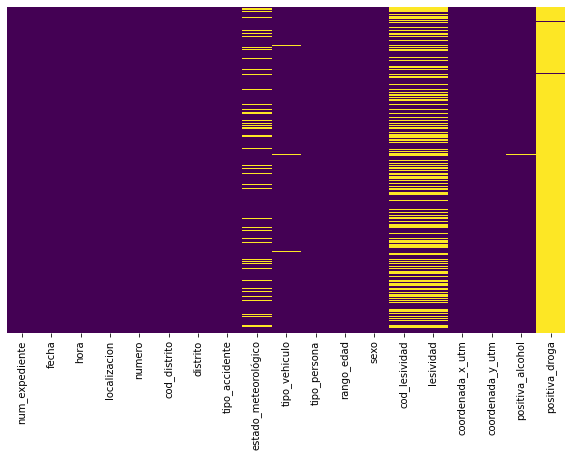

In [8]:
check_nan(df)

In [9]:
df.positiva_droga.unique()

array([nan,  1.])

#### La columna 'positiva_droga' tiene más de un 99% de nulos, así que esta vez la voy a eliminar porque no puedo fiarme de ella de cara a la predicción

In [10]:
df.drop(columns='positiva_droga', inplace=True)

In [11]:
df.head()

,num_expediente,fecha,hora,localizacion,numero,cod_distrito,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,cod_lesividad,lesividad,coordenada_x_utm,coordenada_y_utm,positiva_alcohol
0,2018S017842,2019-02-04,09:10:00,"CALL. ALBERTO AGUILERA, 1",1,1.0,CENTRO,Colisión lateral,Despejado,Motocicleta > 125cc,Conductor,De 45 a 49 años,Hombre,7.0,Asistencia sanitaria sólo en el lugar del acci...,440068.049,4475679.170,N
1,2018S017842,2019-02-04,09:10:00,"CALL. ALBERTO AGUILERA, 1",1,1.0,CENTRO,Colisión lateral,Despejado,Turismo,Conductor,De 30 a 34 años,Mujer,7.0,Asistencia sanitaria sólo en el lugar del acci...,440068.049,4475679.170,N
2,2019S000001,2019-01-01,03:45:00,PASEO. SANTA MARIA DE LA CABEZA / PLAZA. ELIPTICA,168,11.0,CARABANCHEL,Alcance,NaN,Furgoneta,Conductor,De 40 a 44 años,Hombre,NaN,NaN,439139.603,4470836.854,S
3,2019S000001,2019-01-01,03:45:00,PASEO. SANTA MARIA DE LA CABEZA / PLAZA. ELIPTICA,168,11.0,CARABANCHEL,Alcance,NaN,Turismo,Conductor,De 40 a 44 años,Mujer,NaN,NaN,439139.603,4470836.854,N
4,2019S000001,2019-01-01,03:45:00,PASEO. SANTA MARIA DE LA CABEZA / PLAZA. ELIPTICA,168,11.0,CARABANCHEL,Alcance,NaN,Turismo,Conductor,De 45 a 49 años,Mujer,NaN,NaN,439139.603,4470836.854,N


'N nan cols: 12'

numero                   0.003125
cod_distrito             0.003125
distrito                 0.003125
tipo_accidente           0.002500
estado_meteorológico    10.322460
tipo_vehiculo            0.316835
tipo_persona             0.001875
cod_lesividad           44.736283
lesividad               44.736283
coordenada_x_utm         0.016873
coordenada_y_utm         0.016873
positiva_alcohol         0.343707
dtype: float64

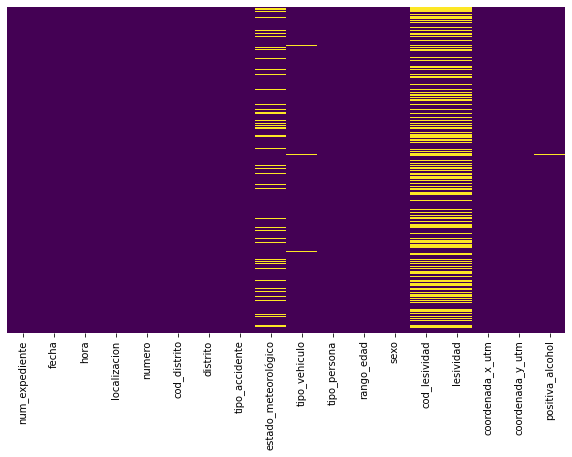

In [12]:
check_nan(df)

In [13]:
df.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160020 entries, 0 to 33992
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   num_expediente        160020 non-null  object        
 1   fecha                 160020 non-null  datetime64[ns]
 2   hora                  160020 non-null  object        
 3   localizacion          160020 non-null  object        
 4   numero                160015 non-null  object        
 5   cod_distrito          160015 non-null  float64       
 6   distrito              160015 non-null  object        
 7   tipo_accidente        160016 non-null  object        
 8   estado_meteorológico  143502 non-null  object        
 9   tipo_vehiculo         159513 non-null  object        
 10  tipo_persona          160017 non-null  object        
 11  rango_edad            160020 non-null  object        
 12  sexo                  160020 non-null  object        
 13  

### Al haber un alto número de filas con valores nulos en casi todos su campos, lo lógico es deshacerse de esos registros, porque no están aportando información de calidad. Además, nuestro objetivo es predecir la severidad de un accidente, por lo que no nos interesa borrar las columnas relacionadas con accidentes.

In [14]:
#Creo un indicador de nulos por fila
num_nan=[]

for fila in df.itertuples():
    
    check=[]
    
    for e in fila:
        
        check.append(pd.isna(e))
        
    num_nan.append(sum(check))
    
num_nan[:10]

[0, 0, 3, 3, 3, 3, 3, 3, 2, 0]

In [15]:
#creo una columna con la lista de número de nulos por fila que acabo de calcular
df['num_nan']=[sum([pd.isna(e) for e in fila]) for fila in df.itertuples()]

In [16]:
df.head()

,num_expediente,fecha,hora,localizacion,numero,cod_distrito,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,cod_lesividad,lesividad,coordenada_x_utm,coordenada_y_utm,positiva_alcohol,num_nan
0,2018S017842,2019-02-04,09:10:00,"CALL. ALBERTO AGUILERA, 1",1,1.0,CENTRO,Colisión lateral,Despejado,Motocicleta > 125cc,Conductor,De 45 a 49 años,Hombre,7.0,Asistencia sanitaria sólo en el lugar del acci...,440068.049,4475679.170,N,0
1,2018S017842,2019-02-04,09:10:00,"CALL. ALBERTO AGUILERA, 1",1,1.0,CENTRO,Colisión lateral,Despejado,Turismo,Conductor,De 30 a 34 años,Mujer,7.0,Asistencia sanitaria sólo en el lugar del acci...,440068.049,4475679.170,N,0
2,2019S000001,2019-01-01,03:45:00,PASEO. SANTA MARIA DE LA CABEZA / PLAZA. ELIPTICA,168,11.0,CARABANCHEL,Alcance,NaN,Furgoneta,Conductor,De 40 a 44 años,Hombre,NaN,NaN,439139.603,4470836.854,S,3
3,2019S000001,2019-01-01,03:45:00,PASEO. SANTA MARIA DE LA CABEZA / PLAZA. ELIPTICA,168,11.0,CARABANCHEL,Alcance,NaN,Turismo,Conductor,De 40 a 44 años,Mujer,NaN,NaN,439139.603,4470836.854,N,3
4,2019S000001,2019-01-01,03:45:00,PASEO. SANTA MARIA DE LA CABEZA / PLAZA. ELIPTICA,168,11.0,CARABANCHEL,Alcance,NaN,Turismo,Conductor,De 45 a 49 años,Mujer,NaN,NaN,439139.603,4470836.854,N,3


#### Vamos a fijar un umbral de 1 nulo por fila, si hay 1 o más nulos por fila, voy a borrarla.

In [17]:
df[df.num_nan>=1].shape, df.shape

((73441, 19), (160020, 19))

In [18]:
df.drop(df[df.num_nan>=1].index, axis=0, inplace=True)

In [19]:
df.reset_index(drop=True, inplace=True)
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21976 entries, 0 to 21975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   num_expediente        21976 non-null  object        
 1   fecha                 21976 non-null  datetime64[ns]
 2   hora                  21976 non-null  object        
 3   localizacion          21976 non-null  object        
 4   numero                21976 non-null  object        
 5   cod_distrito          21976 non-null  float64       
 6   distrito              21976 non-null  object        
 7   tipo_accidente        21976 non-null  object        
 8   estado_meteorológico  21976 non-null  object        
 9   tipo_vehiculo         21976 non-null  object        
 10  tipo_persona          21976 non-null  object        
 11  rango_edad            21976 non-null  object        
 12  sexo                  21976 non-null  object        
 13  cod_lesividad   

#### Ahora borro la columna num_nan porque ya no me sirve

In [20]:
df.drop('num_nan', axis=1, inplace=True) 

'N nan cols: 0'

Series([], dtype: float64)

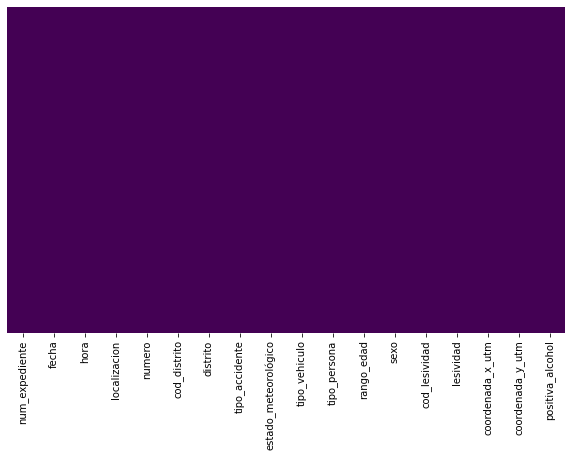

In [21]:
check_nan(df)

#### Ahora creo una columna nueva para positividad de alcohol que sea int. 

In [22]:
#Para ello genero una función en la que si hay positivo en alcohol añade un 1 a la nueva columna y si no un 0:

def positividad_alcohol(x):
    
    if x == 'S':
        return 1
    else:
        return 0


In [23]:
df['positivo_alcohol']=df.positiva_alcohol.apply(positividad_alcohol)
df.positivo_alcohol.unique()

array([0, 1], dtype=int64)

In [24]:
#borro la columna 'positiva_alcohol'.
df.drop('positiva_alcohol', axis=1, inplace=True)  

In [25]:
df.info(memory_usage= 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21976 entries, 0 to 21975
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   num_expediente        21976 non-null  object        
 1   fecha                 21976 non-null  datetime64[ns]
 2   hora                  21976 non-null  object        
 3   localizacion          21976 non-null  object        
 4   numero                21976 non-null  object        
 5   cod_distrito          21976 non-null  float64       
 6   distrito              21976 non-null  object        
 7   tipo_accidente        21976 non-null  object        
 8   estado_meteorológico  21976 non-null  object        
 9   tipo_vehiculo         21976 non-null  object        
 10  tipo_persona          21976 non-null  object        
 11  rango_edad            21976 non-null  object        
 12  sexo                  21976 non-null  object        
 13  cod_lesividad   

In [26]:
df.head()

,num_expediente,fecha,hora,localizacion,numero,cod_distrito,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,cod_lesividad,lesividad,coordenada_x_utm,coordenada_y_utm,positivo_alcohol
0,2019S000009,2019-01-01,08:10:00,CALL. REAL DE ARGANDA / AVDA. LA GAVIA,1,18.0,VILLA DE VALLECAS,Colisión fronto-lateral,Despejado,Turismo,Conductor,De 21 a 24 años,Mujer,14.0,Sin asistencia sanitaria,448457.315,4469839.215,0
1,2019S000009,2019-01-01,08:10:00,CALL. REAL DE ARGANDA / AVDA. LA GAVIA,1,18.0,VILLA DE VALLECAS,Colisión fronto-lateral,Despejado,Turismo,Pasajero,De 25 a 29 años,Hombre,14.0,Sin asistencia sanitaria,448457.315,4469839.215,0
2,2019S000009,2019-01-01,08:10:00,CALL. REAL DE ARGANDA / AVDA. LA GAVIA,1,18.0,VILLA DE VALLECAS,Colisión fronto-lateral,Despejado,Turismo,Pasajero,De 25 a 29 años,Mujer,7.0,Asistencia sanitaria sólo en el lugar del acci...,448457.315,4469839.215,0
3,2019S000017,2019-01-01,22:15:00,CALL. OCA / CALL. PINZON,59,11.0,CARABANCHEL,Colisión fronto-lateral,Despejado,Ciclomotor,Conductor,De 35 a 39 años,Hombre,3.0,Ingreso superior a 24 horas,437178.250,4471177.080,0
4,2019S000022,2019-01-01,12:29:00,"CALL. CONDE DE TORRALBA, 4",4,5.0,CHAMARTÍN,Alcance,Despejado,Turismo,Pasajero,De 65 a 69 años,Mujer,14.0,Sin asistencia sanitaria,441926.445,4480967.858,0


#### Ahora que ya no tenemos nulos, el siguiente paso va a ser crear campos para día, mes, año, hora y día de la semana

In [27]:
#creo un campo fecha en string
df['fecha_str']=df['fecha'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21976 entries, 0 to 21975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   num_expediente        21976 non-null  object        
 1   fecha                 21976 non-null  datetime64[ns]
 2   hora                  21976 non-null  object        
 3   localizacion          21976 non-null  object        
 4   numero                21976 non-null  object        
 5   cod_distrito          21976 non-null  float64       
 6   distrito              21976 non-null  object        
 7   tipo_accidente        21976 non-null  object        
 8   estado_meteorológico  21976 non-null  object        
 9   tipo_vehiculo         21976 non-null  object        
 10  tipo_persona          21976 non-null  object        
 11  rango_edad            21976 non-null  object        
 12  sexo                  21976 non-null  object        
 13  cod_lesividad   

In [29]:
#concateno el campo de fecha string con el de la hora
df['fecha_completa']= df['fecha_str'] + ' ' + df['hora'].astype(str)
df.head()

,num_expediente,fecha,hora,localizacion,numero,cod_distrito,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,cod_lesividad,lesividad,coordenada_x_utm,coordenada_y_utm,positivo_alcohol,fecha_str,fecha_completa
0,2019S000009,2019-01-01,08:10:00,CALL. REAL DE ARGANDA / AVDA. LA GAVIA,1,18.0,VILLA DE VALLECAS,Colisión fronto-lateral,Despejado,Turismo,Conductor,De 21 a 24 años,Mujer,14.0,Sin asistencia sanitaria,448457.315,4469839.215,0,2019-01-01,2019-01-01 08:10:00
1,2019S000009,2019-01-01,08:10:00,CALL. REAL DE ARGANDA / AVDA. LA GAVIA,1,18.0,VILLA DE VALLECAS,Colisión fronto-lateral,Despejado,Turismo,Pasajero,De 25 a 29 años,Hombre,14.0,Sin asistencia sanitaria,448457.315,4469839.215,0,2019-01-01,2019-01-01 08:10:00
2,2019S000009,2019-01-01,08:10:00,CALL. REAL DE ARGANDA / AVDA. LA GAVIA,1,18.0,VILLA DE VALLECAS,Colisión fronto-lateral,Despejado,Turismo,Pasajero,De 25 a 29 años,Mujer,7.0,Asistencia sanitaria sólo en el lugar del acci...,448457.315,4469839.215,0,2019-01-01,2019-01-01 08:10:00
3,2019S000017,2019-01-01,22:15:00,CALL. OCA / CALL. PINZON,59,11.0,CARABANCHEL,Colisión fronto-lateral,Despejado,Ciclomotor,Conductor,De 35 a 39 años,Hombre,3.0,Ingreso superior a 24 horas,437178.250,4471177.080,0,2019-01-01,2019-01-01 22:15:00
4,2019S000022,2019-01-01,12:29:00,"CALL. CONDE DE TORRALBA, 4",4,5.0,CHAMARTÍN,Alcance,Despejado,Turismo,Pasajero,De 65 a 69 años,Mujer,14.0,Sin asistencia sanitaria,441926.445,4480967.858,0,2019-01-01,2019-01-01 12:29:00


In [30]:
#lo convierto a tipo datetime
df.fecha_completa=pd.to_datetime(df.fecha_completa)

df.head()

,num_expediente,fecha,hora,localizacion,numero,cod_distrito,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,cod_lesividad,lesividad,coordenada_x_utm,coordenada_y_utm,positivo_alcohol,fecha_str,fecha_completa
0,2019S000009,2019-01-01,08:10:00,CALL. REAL DE ARGANDA / AVDA. LA GAVIA,1,18.0,VILLA DE VALLECAS,Colisión fronto-lateral,Despejado,Turismo,Conductor,De 21 a 24 años,Mujer,14.0,Sin asistencia sanitaria,448457.315,4469839.215,0,2019-01-01,2019-01-01 08:10:00
1,2019S000009,2019-01-01,08:10:00,CALL. REAL DE ARGANDA / AVDA. LA GAVIA,1,18.0,VILLA DE VALLECAS,Colisión fronto-lateral,Despejado,Turismo,Pasajero,De 25 a 29 años,Hombre,14.0,Sin asistencia sanitaria,448457.315,4469839.215,0,2019-01-01,2019-01-01 08:10:00
2,2019S000009,2019-01-01,08:10:00,CALL. REAL DE ARGANDA / AVDA. LA GAVIA,1,18.0,VILLA DE VALLECAS,Colisión fronto-lateral,Despejado,Turismo,Pasajero,De 25 a 29 años,Mujer,7.0,Asistencia sanitaria sólo en el lugar del acci...,448457.315,4469839.215,0,2019-01-01,2019-01-01 08:10:00
3,2019S000017,2019-01-01,22:15:00,CALL. OCA / CALL. PINZON,59,11.0,CARABANCHEL,Colisión fronto-lateral,Despejado,Ciclomotor,Conductor,De 35 a 39 años,Hombre,3.0,Ingreso superior a 24 horas,437178.250,4471177.080,0,2019-01-01,2019-01-01 22:15:00
4,2019S000022,2019-01-01,12:29:00,"CALL. CONDE DE TORRALBA, 4",4,5.0,CHAMARTÍN,Alcance,Despejado,Turismo,Pasajero,De 65 a 69 años,Mujer,14.0,Sin asistencia sanitaria,441926.445,4480967.858,0,2019-01-01,2019-01-01 12:29:00


In [31]:
#elimino la columna fecha_str
df.drop('fecha_str', axis=1, inplace=True) 

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21976 entries, 0 to 21975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   num_expediente        21976 non-null  object        
 1   fecha                 21976 non-null  datetime64[ns]
 2   hora                  21976 non-null  object        
 3   localizacion          21976 non-null  object        
 4   numero                21976 non-null  object        
 5   cod_distrito          21976 non-null  float64       
 6   distrito              21976 non-null  object        
 7   tipo_accidente        21976 non-null  object        
 8   estado_meteorológico  21976 non-null  object        
 9   tipo_vehiculo         21976 non-null  object        
 10  tipo_persona          21976 non-null  object        
 11  rango_edad            21976 non-null  object        
 12  sexo                  21976 non-null  object        
 13  cod_lesividad   

In [37]:
# Extraigo año, mes, día, hora y día de la semana
df['ano']=df['fecha_completa'].dt.year
df['mes']=df['fecha_completa'].dt.month
df['dia']=df['fecha_completa'].dt.day
df['hora_']=df['fecha_completa'].dt.hour
df['dia_semana']=df['fecha_completa'].dt.weekday #0 es lunes, 6 es domingo

In [40]:
df.head()

,num_expediente,fecha,hora,localizacion,numero,cod_distrito,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,cod_lesividad,lesividad,coordenada_x_utm,coordenada_y_utm,positivo_alcohol,fecha_completa,ano,mes,dia,hora_,dia_semana
0,2019S000009,2019-01-01,08:10:00,CALL. REAL DE ARGANDA / AVDA. LA GAVIA,1,18.0,VILLA DE VALLECAS,Colisión fronto-lateral,Despejado,Turismo,Conductor,De 21 a 24 años,Mujer,14.0,Sin asistencia sanitaria,448457.315,4469839.215,0,2019-01-01 08:10:00,2019,1,1,8,1
1,2019S000009,2019-01-01,08:10:00,CALL. REAL DE ARGANDA / AVDA. LA GAVIA,1,18.0,VILLA DE VALLECAS,Colisión fronto-lateral,Despejado,Turismo,Pasajero,De 25 a 29 años,Hombre,14.0,Sin asistencia sanitaria,448457.315,4469839.215,0,2019-01-01 08:10:00,2019,1,1,8,1
2,2019S000009,2019-01-01,08:10:00,CALL. REAL DE ARGANDA / AVDA. LA GAVIA,1,18.0,VILLA DE VALLECAS,Colisión fronto-lateral,Despejado,Turismo,Pasajero,De 25 a 29 años,Mujer,7.0,Asistencia sanitaria sólo en el lugar del acci...,448457.315,4469839.215,0,2019-01-01 08:10:00,2019,1,1,8,1
3,2019S000017,2019-01-01,22:15:00,CALL. OCA / CALL. PINZON,59,11.0,CARABANCHEL,Colisión fronto-lateral,Despejado,Ciclomotor,Conductor,De 35 a 39 años,Hombre,3.0,Ingreso superior a 24 horas,437178.250,4471177.080,0,2019-01-01 22:15:00,2019,1,1,22,1
4,2019S000022,2019-01-01,12:29:00,"CALL. CONDE DE TORRALBA, 4",4,5.0,CHAMARTÍN,Alcance,Despejado,Turismo,Pasajero,De 65 a 69 años,Mujer,14.0,Sin asistencia sanitaria,441926.445,4480967.858,0,2019-01-01 12:29:00,2019,1,1,12,1


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21976 entries, 0 to 21975
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   num_expediente        21976 non-null  object        
 1   fecha                 21976 non-null  datetime64[ns]
 2   hora                  21976 non-null  object        
 3   localizacion          21976 non-null  object        
 4   numero                21976 non-null  object        
 5   cod_distrito          21976 non-null  float64       
 6   distrito              21976 non-null  object        
 7   tipo_accidente        21976 non-null  object        
 8   estado_meteorológico  21976 non-null  object        
 9   tipo_vehiculo         21976 non-null  object        
 10  tipo_persona          21976 non-null  object        
 11  rango_edad            21976 non-null  object        
 12  sexo                  21976 non-null  object        
 13  cod_lesividad   

In [42]:
#elimino la antigua columna fecha porque ya tengo otra más completa
df.drop('fecha', axis=1, inplace=True)  

In [43]:
#voy a poner la columna fecha_completa como la segunda para que quede más ordenado
second_column = df.pop('fecha_completa')
  
# insert column using insert(position,column_name,
# second_column) function
df.insert(1, 'fecha_completa', second_column)
df.head()

,num_expediente,fecha_completa,hora,localizacion,numero,cod_distrito,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,cod_lesividad,lesividad,coordenada_x_utm,coordenada_y_utm,positivo_alcohol,ano,mes,dia,hora_,dia_semana
0,2019S000009,2019-01-01 08:10:00,08:10:00,CALL. REAL DE ARGANDA / AVDA. LA GAVIA,1,18.0,VILLA DE VALLECAS,Colisión fronto-lateral,Despejado,Turismo,Conductor,De 21 a 24 años,Mujer,14.0,Sin asistencia sanitaria,448457.315,4469839.215,0,2019,1,1,8,1
1,2019S000009,2019-01-01 08:10:00,08:10:00,CALL. REAL DE ARGANDA / AVDA. LA GAVIA,1,18.0,VILLA DE VALLECAS,Colisión fronto-lateral,Despejado,Turismo,Pasajero,De 25 a 29 años,Hombre,14.0,Sin asistencia sanitaria,448457.315,4469839.215,0,2019,1,1,8,1
2,2019S000009,2019-01-01 08:10:00,08:10:00,CALL. REAL DE ARGANDA / AVDA. LA GAVIA,1,18.0,VILLA DE VALLECAS,Colisión fronto-lateral,Despejado,Turismo,Pasajero,De 25 a 29 años,Mujer,7.0,Asistencia sanitaria sólo en el lugar del acci...,448457.315,4469839.215,0,2019,1,1,8,1
3,2019S000017,2019-01-01 22:15:00,22:15:00,CALL. OCA / CALL. PINZON,59,11.0,CARABANCHEL,Colisión fronto-lateral,Despejado,Ciclomotor,Conductor,De 35 a 39 años,Hombre,3.0,Ingreso superior a 24 horas,437178.250,4471177.080,0,2019,1,1,22,1
4,2019S000022,2019-01-01 12:29:00,12:29:00,"CALL. CONDE DE TORRALBA, 4",4,5.0,CHAMARTÍN,Alcance,Despejado,Turismo,Pasajero,De 65 a 69 años,Mujer,14.0,Sin asistencia sanitaria,441926.445,4480967.858,0,2019,1,1,12,1


In [44]:
df1= df.copy()

#### Voy a crear dos nuevas columnas con latitud y longitud a partir de las columnas de coordenadas porque están en UTM

In [45]:
%pip install utm
%pip install pyproj

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [46]:
import utm
import pyproj as pp

In [47]:
utm30_etrs89 = pp.Proj(init='epsg:25830') #le paso la proyección ETRS89 UTM Zona 30 N

In [48]:
df1[['long', 'lat']] = df.apply(lambda row:utm30_etrs89(row['coordenada_x_utm'], row['coordenada_y_utm'], inverse=True), axis=1).apply(pd.Series)

In [49]:
df1.head()

,num_expediente,fecha_completa,hora,localizacion,numero,cod_distrito,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,cod_lesividad,lesividad,coordenada_x_utm,coordenada_y_utm,positivo_alcohol,ano,mes,dia,hora_,dia_semana,long,lat
0,2019S000009,2019-01-01 08:10:00,08:10:00,CALL. REAL DE ARGANDA / AVDA. LA GAVIA,1,18.0,VILLA DE VALLECAS,Colisión fronto-lateral,Despejado,Turismo,Conductor,De 21 a 24 años,Mujer,14.0,Sin asistencia sanitaria,448457.315,4469839.215,0,2019,1,1,8,1,-3.607185,40.377544
1,2019S000009,2019-01-01 08:10:00,08:10:00,CALL. REAL DE ARGANDA / AVDA. LA GAVIA,1,18.0,VILLA DE VALLECAS,Colisión fronto-lateral,Despejado,Turismo,Pasajero,De 25 a 29 años,Hombre,14.0,Sin asistencia sanitaria,448457.315,4469839.215,0,2019,1,1,8,1,-3.607185,40.377544
2,2019S000009,2019-01-01 08:10:00,08:10:00,CALL. REAL DE ARGANDA / AVDA. LA GAVIA,1,18.0,VILLA DE VALLECAS,Colisión fronto-lateral,Despejado,Turismo,Pasajero,De 25 a 29 años,Mujer,7.0,Asistencia sanitaria sólo en el lugar del acci...,448457.315,4469839.215,0,2019,1,1,8,1,-3.607185,40.377544
3,2019S000017,2019-01-01 22:15:00,22:15:00,CALL. OCA / CALL. PINZON,59,11.0,CARABANCHEL,Colisión fronto-lateral,Despejado,Ciclomotor,Conductor,De 35 a 39 años,Hombre,3.0,Ingreso superior a 24 horas,437178.250,4471177.080,0,2019,1,1,22,1,-3.740177,40.388822
4,2019S000022,2019-01-01 12:29:00,12:29:00,"CALL. CONDE DE TORRALBA, 4",4,5.0,CHAMARTÍN,Alcance,Despejado,Turismo,Pasajero,De 65 a 69 años,Mujer,14.0,Sin asistencia sanitaria,441926.445,4480967.858,0,2019,1,1,12,1,-3.685131,40.477367


In [50]:
df1.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21976 entries, 0 to 21975
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   num_expediente        21976 non-null  object        
 1   fecha_completa        21976 non-null  datetime64[ns]
 2   hora                  21976 non-null  object        
 3   localizacion          21976 non-null  object        
 4   numero                21976 non-null  object        
 5   cod_distrito          21976 non-null  float64       
 6   distrito              21976 non-null  object        
 7   tipo_accidente        21976 non-null  object        
 8   estado_meteorológico  21976 non-null  object        
 9   tipo_vehiculo         21976 non-null  object        
 10  tipo_persona          21976 non-null  object        
 11  rango_edad            21976 non-null  object        
 12  sexo                  21976 non-null  object        
 13  cod_lesividad   

In [51]:
df2 = df1.copy()

In [52]:
#elimino las columnas de coordenadas en utm porque ya no las necesito
df2.drop('coordenada_x_utm', axis=1, inplace=True)
df2.drop('coordenada_y_utm', axis=1, inplace=True)

In [53]:
#renombro la columna 'fecha_completa' como 'fecha'
df2.rename(columns={'fecha_completa':'fecha'}, inplace=True)

In [54]:
df2.head()

,num_expediente,fecha,hora,localizacion,numero,cod_distrito,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,cod_lesividad,lesividad,positivo_alcohol,ano,mes,dia,hora_,dia_semana,long,lat
0,2019S000009,2019-01-01 08:10:00,08:10:00,CALL. REAL DE ARGANDA / AVDA. LA GAVIA,1,18.0,VILLA DE VALLECAS,Colisión fronto-lateral,Despejado,Turismo,Conductor,De 21 a 24 años,Mujer,14.0,Sin asistencia sanitaria,0,2019,1,1,8,1,-3.607185,40.377544
1,2019S000009,2019-01-01 08:10:00,08:10:00,CALL. REAL DE ARGANDA / AVDA. LA GAVIA,1,18.0,VILLA DE VALLECAS,Colisión fronto-lateral,Despejado,Turismo,Pasajero,De 25 a 29 años,Hombre,14.0,Sin asistencia sanitaria,0,2019,1,1,8,1,-3.607185,40.377544
2,2019S000009,2019-01-01 08:10:00,08:10:00,CALL. REAL DE ARGANDA / AVDA. LA GAVIA,1,18.0,VILLA DE VALLECAS,Colisión fronto-lateral,Despejado,Turismo,Pasajero,De 25 a 29 años,Mujer,7.0,Asistencia sanitaria sólo en el lugar del acci...,0,2019,1,1,8,1,-3.607185,40.377544
3,2019S000017,2019-01-01 22:15:00,22:15:00,CALL. OCA / CALL. PINZON,59,11.0,CARABANCHEL,Colisión fronto-lateral,Despejado,Ciclomotor,Conductor,De 35 a 39 años,Hombre,3.0,Ingreso superior a 24 horas,0,2019,1,1,22,1,-3.740177,40.388822
4,2019S000022,2019-01-01 12:29:00,12:29:00,"CALL. CONDE DE TORRALBA, 4",4,5.0,CHAMARTÍN,Alcance,Despejado,Turismo,Pasajero,De 65 a 69 años,Mujer,14.0,Sin asistencia sanitaria,0,2019,1,1,12,1,-3.685131,40.477367


In [55]:
df3 = df2.copy()

#### Voy a crear una columna que sirva de primary key

In [56]:
df3.reset_index(drop=True, inplace=True)

In [57]:
df3.tail()

,num_expediente,fecha,hora,localizacion,numero,cod_distrito,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,cod_lesividad,lesividad,positivo_alcohol,ano,mes,dia,hora_,dia_semana,long,lat
21971,2022S028483,2022-09-30 23:50:00,23:50:00,CALL. ALCALA / CALL. ALEGRIA DE ORIA,491,20.0,SAN BLAS-CANILLEJAS,Colisión frontal,Despejado,Motocicleta > 125cc,Pasajero,De 25 a 29 años,Mujer,2.0,Ingreso inferior o igual a 24 horas,0,2022,9,30,23,4,-3.630571,40.439939
21972,2022S028483,2022-09-30 23:50:00,23:50:00,CALL. ALCALA / CALL. ALEGRIA DE ORIA,491,20.0,SAN BLAS-CANILLEJAS,Colisión frontal,Despejado,Turismo,Conductor,De 60 a 64 años,Hombre,14.0,Sin asistencia sanitaria,0,2022,9,30,23,4,-3.630571,40.439939
21973,2022S028528,2022-09-30 11:50:00,11:50:00,"CTRA. CASTILLA, +00100S",+00100S,9.0,MONCLOA-ARAVACA,Vuelco,Despejado,Otros vehículos con motor,Pasajero,De 35 a 39 años,Hombre,14.0,Sin asistencia sanitaria,0,2022,9,30,11,4,-3.753733,40.448948
21974,2022S028529,2022-09-30 13:30:00,13:30:00,"AUTOV. M-30, +00680E Lateral",+00700E,15.0,CIUDAD LINEAL,Alcance,Despejado,Turismo,Conductor,De 30 a 34 años,Hombre,14.0,Sin asistencia sanitaria,0,2022,9,30,13,4,-3.659188,40.424024
21975,2022S029179,2022-09-20 22:00:00,22:00:00,"AUTOV. M-30, CALZADA INTERIOR PK 31.800",+03180I,5.0,CHAMARTÍN,Otro,Despejado,Turismo,Conductor,De 30 a 34 años,Hombre,14.0,Sin asistencia sanitaria,0,2022,9,20,22,1,-3.680056,40.483420


In [58]:
#creo la columna id en base al índice
df3['id'] = range(len(df3))


In [59]:
df3.tail()

,num_expediente,fecha,hora,localizacion,numero,cod_distrito,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,cod_lesividad,lesividad,positivo_alcohol,ano,mes,dia,hora_,dia_semana,long,lat,id
21971,2022S028483,2022-09-30 23:50:00,23:50:00,CALL. ALCALA / CALL. ALEGRIA DE ORIA,491,20.0,SAN BLAS-CANILLEJAS,Colisión frontal,Despejado,Motocicleta > 125cc,Pasajero,De 25 a 29 años,Mujer,2.0,Ingreso inferior o igual a 24 horas,0,2022,9,30,23,4,-3.630571,40.439939,21971
21972,2022S028483,2022-09-30 23:50:00,23:50:00,CALL. ALCALA / CALL. ALEGRIA DE ORIA,491,20.0,SAN BLAS-CANILLEJAS,Colisión frontal,Despejado,Turismo,Conductor,De 60 a 64 años,Hombre,14.0,Sin asistencia sanitaria,0,2022,9,30,23,4,-3.630571,40.439939,21972
21973,2022S028528,2022-09-30 11:50:00,11:50:00,"CTRA. CASTILLA, +00100S",+00100S,9.0,MONCLOA-ARAVACA,Vuelco,Despejado,Otros vehículos con motor,Pasajero,De 35 a 39 años,Hombre,14.0,Sin asistencia sanitaria,0,2022,9,30,11,4,-3.753733,40.448948,21973
21974,2022S028529,2022-09-30 13:30:00,13:30:00,"AUTOV. M-30, +00680E Lateral",+00700E,15.0,CIUDAD LINEAL,Alcance,Despejado,Turismo,Conductor,De 30 a 34 años,Hombre,14.0,Sin asistencia sanitaria,0,2022,9,30,13,4,-3.659188,40.424024,21974
21975,2022S029179,2022-09-20 22:00:00,22:00:00,"AUTOV. M-30, CALZADA INTERIOR PK 31.800",+03180I,5.0,CHAMARTÍN,Otro,Despejado,Turismo,Conductor,De 30 a 34 años,Hombre,14.0,Sin asistencia sanitaria,0,2022,9,20,22,1,-3.680056,40.483420,21975


In [60]:
#pongo la columna 'id' como primera 
first_c = df3.pop('id')
  
# insert column using insert(position,column_name,
# first_column) function
df3.insert(0, 'id', first_c)
df3.head()

,id,num_expediente,fecha,hora,localizacion,numero,cod_distrito,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,cod_lesividad,lesividad,positivo_alcohol,ano,mes,dia,hora_,dia_semana,long,lat
0,0,2019S000009,2019-01-01 08:10:00,08:10:00,CALL. REAL DE ARGANDA / AVDA. LA GAVIA,1,18.0,VILLA DE VALLECAS,Colisión fronto-lateral,Despejado,Turismo,Conductor,De 21 a 24 años,Mujer,14.0,Sin asistencia sanitaria,0,2019,1,1,8,1,-3.607185,40.377544
1,1,2019S000009,2019-01-01 08:10:00,08:10:00,CALL. REAL DE ARGANDA / AVDA. LA GAVIA,1,18.0,VILLA DE VALLECAS,Colisión fronto-lateral,Despejado,Turismo,Pasajero,De 25 a 29 años,Hombre,14.0,Sin asistencia sanitaria,0,2019,1,1,8,1,-3.607185,40.377544
2,2,2019S000009,2019-01-01 08:10:00,08:10:00,CALL. REAL DE ARGANDA / AVDA. LA GAVIA,1,18.0,VILLA DE VALLECAS,Colisión fronto-lateral,Despejado,Turismo,Pasajero,De 25 a 29 años,Mujer,7.0,Asistencia sanitaria sólo en el lugar del acci...,0,2019,1,1,8,1,-3.607185,40.377544
3,3,2019S000017,2019-01-01 22:15:00,22:15:00,CALL. OCA / CALL. PINZON,59,11.0,CARABANCHEL,Colisión fronto-lateral,Despejado,Ciclomotor,Conductor,De 35 a 39 años,Hombre,3.0,Ingreso superior a 24 horas,0,2019,1,1,22,1,-3.740177,40.388822
4,4,2019S000022,2019-01-01 12:29:00,12:29:00,"CALL. CONDE DE TORRALBA, 4",4,5.0,CHAMARTÍN,Alcance,Despejado,Turismo,Pasajero,De 65 a 69 años,Mujer,14.0,Sin asistencia sanitaria,0,2019,1,1,12,1,-3.685131,40.477367


#### Exploramos los datos de nuestra variable objetivo (lesividad) para ver si podemos reducir el número de valores únicos.

In [61]:
df3.lesividad.value_counts()

Sin asistencia sanitaria                                     11758
Asistencia sanitaria sólo en el lugar del accidente           5411
Ingreso inferior o igual a 24 horas                           1590
Atención en urgencias sin posterior ingreso                   1110
Asistencia sanitaria inmediata en centro de salud o mutua     1083
Asistencia sanitaria ambulatoria con posterioridad             517
Ingreso superior a 24 horas                                    474
Fallecido 24 horas                                              32
Se desconoce                                                     1
Name: lesividad, dtype: int64

#### Me gustaría clasificar la severidad del accidente en base a las lesividades que tengan los afectados, por lo que podría reducir a tres valores únicos (leve, media y grave). Severidad leve tendrá valor 0, media 1 y grave 2.

In [64]:
#creo una nueva columna de severidad a partir de la de lesividad. 
lst = []
for i in df3.lesividad:
    if i == 'Sin asistencia sanitaria' or i == 'Asistencia sanitaria sólo en el lugar del accidente' or i == 'Ingreso inferior o igual a 24 horas' or i == 'Atención en urgencias sin posterior ingreso':
        lst.append(0)
    elif i == 'Asistencia sanitaria inmediata en centro de salud o mutua' or i == 'Asistencia sanitaria ambulatoria con posterioridad':
        lst.append(1)
    else:
        lst.append(2)

lst[:20]

[0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0]

In [65]:
df3['severidad'] = lst
df3.head()

,id,num_expediente,fecha,hora,localizacion,numero,cod_distrito,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,cod_lesividad,lesividad,positivo_alcohol,ano,mes,dia,hora_,dia_semana,long,lat,severidad
0,0,2019S000009,2019-01-01 08:10:00,08:10:00,CALL. REAL DE ARGANDA / AVDA. LA GAVIA,1,18.0,VILLA DE VALLECAS,Colisión fronto-lateral,Despejado,Turismo,Conductor,De 21 a 24 años,Mujer,14.0,Sin asistencia sanitaria,0,2019,1,1,8,1,-3.607185,40.377544,0
1,1,2019S000009,2019-01-01 08:10:00,08:10:00,CALL. REAL DE ARGANDA / AVDA. LA GAVIA,1,18.0,VILLA DE VALLECAS,Colisión fronto-lateral,Despejado,Turismo,Pasajero,De 25 a 29 años,Hombre,14.0,Sin asistencia sanitaria,0,2019,1,1,8,1,-3.607185,40.377544,0
2,2,2019S000009,2019-01-01 08:10:00,08:10:00,CALL. REAL DE ARGANDA / AVDA. LA GAVIA,1,18.0,VILLA DE VALLECAS,Colisión fronto-lateral,Despejado,Turismo,Pasajero,De 25 a 29 años,Mujer,7.0,Asistencia sanitaria sólo en el lugar del acci...,0,2019,1,1,8,1,-3.607185,40.377544,0
3,3,2019S000017,2019-01-01 22:15:00,22:15:00,CALL. OCA / CALL. PINZON,59,11.0,CARABANCHEL,Colisión fronto-lateral,Despejado,Ciclomotor,Conductor,De 35 a 39 años,Hombre,3.0,Ingreso superior a 24 horas,0,2019,1,1,22,1,-3.740177,40.388822,2
4,4,2019S000022,2019-01-01 12:29:00,12:29:00,"CALL. CONDE DE TORRALBA, 4",4,5.0,CHAMARTÍN,Alcance,Despejado,Turismo,Pasajero,De 65 a 69 años,Mujer,14.0,Sin asistencia sanitaria,0,2019,1,1,12,1,-3.685131,40.477367,0


In [69]:
df3.severidad.value_counts()

0    19869
1     1600
2      507
Name: severidad, dtype: int64

In [70]:
df3.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21976 entries, 0 to 21975
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    21976 non-null  int64         
 1   num_expediente        21976 non-null  object        
 2   fecha                 21976 non-null  datetime64[ns]
 3   hora                  21976 non-null  object        
 4   localizacion          21976 non-null  object        
 5   numero                21976 non-null  object        
 6   cod_distrito          21976 non-null  float64       
 7   distrito              21976 non-null  object        
 8   tipo_accidente        21976 non-null  object        
 9   estado_meteorológico  21976 non-null  object        
 10  tipo_vehiculo         21976 non-null  object        
 11  tipo_persona          21976 non-null  object        
 12  rango_edad            21976 non-null  object        
 13  sexo            

In [71]:
#convierto el código de distrito a int
df3.cod_distrito = df3.cod_distrito.astype(int)

In [72]:
df3.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21976 entries, 0 to 21975
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    21976 non-null  int64         
 1   num_expediente        21976 non-null  object        
 2   fecha                 21976 non-null  datetime64[ns]
 3   hora                  21976 non-null  object        
 4   localizacion          21976 non-null  object        
 5   numero                21976 non-null  object        
 6   cod_distrito          21976 non-null  int32         
 7   distrito              21976 non-null  object        
 8   tipo_accidente        21976 non-null  object        
 9   estado_meteorológico  21976 non-null  object        
 10  tipo_vehiculo         21976 non-null  object        
 11  tipo_persona          21976 non-null  object        
 12  rango_edad            21976 non-null  object        
 13  sexo            

#### Vamos a eliminar una serie de columnas que no sirven para nuestro modelo de predicción.

In [83]:

df3.drop('', axis=1, inplace=True)

#### Comprobamos duplicados que hayan podido quedar

In [85]:
df3.drop_duplicates().shape==df3.shape #hay duplicados

False

In [86]:
#comprobamos cuáles son los duplicados
duplicateRows = df3[df.duplicated()]
duplicateRows.head()

,num_expediente,fecha,hora,localizacion,numero,cod_distrito,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,lesividad,positivo_droga,positivo_alcohol,ano,mes,dia,long,lat
11,2019S000002,2019-01-01,03:50:00,"CALL. CUART DE POBLET, 65",65,10,LATINA,Choque contra obstáculo fijo,Despejado,Turismo,Conductor,Desconocido,Desconocido,unknown,0,0,2019,1,1,-3.748561,40.396457
20,2019S000006,2019-01-01,08:10:00,CALL. CASTRO DE ORO / CALL. FERREIRA,16,11,CARABANCHEL,Choque contra obstáculo fijo,Despejado,Turismo,Conductor,Desconocido,Desconocido,unknown,0,0,2019,1,1,-3.729127,40.388839
23,2019S000007,2019-01-01,08:05:00,CALL. ARROYO FONTARRON / CALL. HACIENDA DE PAV...,1,14,MORATALAZ,Colisión fronto-lateral,Despejado,Autobús,Pasajero,De 15 a 17 años,Hombre,Sin asistencia sanitaria,0,0,2019,1,1,-3.628414,40.398906
27,2019S000007,2019-01-01,08:05:00,CALL. ARROYO FONTARRON / CALL. HACIENDA DE PAV...,1,14,MORATALAZ,Colisión fronto-lateral,Despejado,Turismo,Pasajero,De 18 a 20 años,Hombre,Sin asistencia sanitaria,0,0,2019,1,1,-3.628414,40.398906
37,2019S000014,2019-01-01,15:55:00,"CALL. PUEBLA DE SANABRIA, 2",2,17,VILLAVERDE,Choque contra obstáculo fijo,Despejado,Turismo,Conductor,Desconocido,Desconocido,unknown,0,0,2019,1,1,-3.713123,40.349980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33808,2022S028343,2022-09-29,19:15:00,"A-6 KM 3,600 DECRECIENTE",+01400E,9,MONCLOA-ARAVACA,Colisión múltiple,Lluvia débil,Turismo,Conductor,De 25 a 29 años,Mujer,Sin asistencia sanitaria,0,0,2022,9,29,-3.727691,40.440379
33816,2022S028345,2022-09-29,22:45:00,"CALL. SANTA HORTENSIA, 35",35,5,CHAMARTÍN,Choque contra obstáculo fijo,Despejado,Turismo,Conductor,Desconocido,Desconocido,unknown,0,0,2022,9,29,-3.665806,40.444012
33824,2022S028350,2022-09-30,00:01:00,"M-30 PK 8,400 C-1 VIA SERVICIO",+00800I,3,RETIRO,Alcance,Despejado,Turismo,Pasajero,De 25 a 29 años,Hombre,Sin asistencia sanitaria,0,0,2022,9,30,-3.662682,40.411899
33897,2022S028401,2022-09-30,17:06:00,"AVDA. MEMORIA, 1",1,9,MONCLOA-ARAVACA,Alcance,unknown,Turismo,Conductor,Desconocido,Desconocido,unknown,0,0,2022,9,30,-3.724018,40.437736


In [87]:
df3.loc[df3['num_expediente'] == '2019S000002']

,num_expediente,fecha,hora,localizacion,numero,cod_distrito,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,lesividad,positivo_droga,positivo_alcohol,ano,mes,dia,long,lat
8,2019S000002,2019-01-01,03:50:00,"CALL. CUART DE POBLET, 65",65,10,LATINA,Choque contra obstáculo fijo,Despejado,Furgoneta,Conductor,Desconocido,Desconocido,unknown,0,0,2019,1,1,-3.748561,40.396457
9,2019S000002,2019-01-01,03:50:00,"CALL. CUART DE POBLET, 65",65,10,LATINA,Choque contra obstáculo fijo,Despejado,Turismo,Conductor,De 21 a 24 años,Hombre,Ingreso inferior o igual a 24 horas,0,0,2019,1,1,-3.748561,40.396457
10,2019S000002,2019-01-01,03:50:00,"CALL. CUART DE POBLET, 65",65,10,LATINA,Choque contra obstáculo fijo,Despejado,Turismo,Conductor,Desconocido,Desconocido,unknown,0,0,2019,1,1,-3.748561,40.396457
11,2019S000002,2019-01-01,03:50:00,"CALL. CUART DE POBLET, 65",65,10,LATINA,Choque contra obstáculo fijo,Despejado,Turismo,Conductor,Desconocido,Desconocido,unknown,0,0,2019,1,1,-3.748561,40.396457


observo que los duplicados pueden no serlo en realidad, porque puede haber datos iguales para dos personas afectadas en un accidente porque sean dos personas pertenecientes a distintos vehículos

#### Por último, guardamos el dataframe en un csv

In [112]:
df3.to_csv('../data/accidentes.csv', index=False)

# BONUS

voy a hacer el join que he hecho en sql aquí en pandas. Para ello voy a llamar de igual manera a las columnas 'cod_distirito' e 'id_distrito'

In [7]:
df_densidad = pd.read_csv('../data/densidad.csv')
df_demographics = pd.read_csv('../data/demographics.csv')
df_accidentes = pd.read_csv('../data/accidentes.csv')


In [8]:
df_densidad.rename(columns={'id_distrito':'cod_distrito'}, inplace=True)

In [9]:
df_demographics.rename(columns={'id_distrito':'cod_distrito'}, inplace=True)

In [10]:
#hago el merge para las tres tablas de una vez
import functools as ft
dfs = [df_accidentes, df_densidad, df_demographics]
accidentes = ft.reduce(lambda left, right: pd.merge(left, right, on='cod_distrito'), dfs)

In [13]:
accidentes.head()

,id,num_expediente,fecha,hora,localizacion,numero,cod_distrito,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,lesividad,positivo_droga,positivo_alcohol,ano,mes,dia,long,lat,nombre_distrito,densidad_pob,edad_media,pob_men_18_perc,pob_may_65_perc,pob_adulta_perc
0,0,2018S017842,2019-02-04,09:10:00,"CALL. ALBERTO AGUILERA, 1",1,1,CENTRO,Colisión lateral,Despejado,Motocicleta > 125cc,Conductor,De 45 a 49 años,Hombre,Asistencia sanitaria sólo en el lugar del acci...,0,0,2019,2,4,-3.706555,40.429592,Centro,252.34,43.5,8.5,15.8,75.7
1,1,2018S017842,2019-02-04,09:10:00,"CALL. ALBERTO AGUILERA, 1",1,1,CENTRO,Colisión lateral,Despejado,Turismo,Conductor,De 30 a 34 años,Mujer,Asistencia sanitaria sólo en el lugar del acci...,0,0,2019,2,4,-3.706555,40.429592,Centro,252.34,43.5,8.5,15.8,75.7
2,207,2019S000349,2019-01-06,01:34:00,CUSTA. SAN VICENTE / CALL. BAILEN,1,1,CENTRO,Colisión lateral,Despejado,Turismo,Conductor,De 40 a 44 años,Hombre,unknown,0,0,2019,1,6,-3.721464,40.418879,Centro,252.34,43.5,8.5,15.8,75.7
3,208,2019S000349,2019-01-06,01:34:00,CUSTA. SAN VICENTE / CALL. BAILEN,1,1,CENTRO,Colisión lateral,Despejado,Turismo,Conductor,De 50 a 54 años,Mujer,unknown,1,0,2019,1,6,-3.721464,40.418879,Centro,252.34,43.5,8.5,15.8,75.7
4,256,2019S000480,2019-01-05,01:20:00,PLAZA. COLON / CALL. JORGE JUAN,1,1,CENTRO,Colisión fronto-lateral,Despejado,Turismo,Conductor,De 21 a 24 años,Mujer,unknown,0,0,2019,1,5,-3.690424,40.424641,Centro,252.34,43.5,8.5,15.8,75.7
